In [9]:
import numpy as np
import pyvista as pv
import pickle
import matplotlib.pyplot as plt
import colorcet as cc

from kale.algorithms import contour_banded
%config InlineBackend.figure_format = "retina"


In [2]:
# Requires PyVista 0.38.1
pv.set_jupyter_backend("server")
pv.global_theme.trame.interactive_ratio = 2
pv.global_theme.trame.still_ratio = 2
pv.global_theme.image_scale = 2  # upscales the saved screenshots/video frames

In [3]:
MESH_GEOMETRY_FILE_NAME = "nankai_121728_clean.vtk"
MESH_VALUES_FILE_NAME = "2023_03_04_00_02_03.hdf"
MESH_Z_SCALE = 0.025
TIME_STEP_INTERESTING = 1000
CONTOUR_LINE_WIDTH = 1
CONTOUR_LINE_COLOR = "black"
COLOR_MAPS = {
    "cumulative_slip": "CET_L19",  #'CET_C3',
    "geometric_moment": "CET_R3",
    "last_event_slip": "CET_L19",
    "loading_rate": "CET_C3",
}

COLORBAR_FONT_SIZE = 34
AXES_FONT_SIZE = 26
TIMESTEP_FONT_SIZE = 12

SCALAR_BAR_OPTS = dict(
    # Position (coordinates are on the viewport)
    vertical=True,
    height=0.20,
    width=0.05,
    position_x=0.05,
    position_y=0.40,
    # Labels
    title_font_size=AXES_FONT_SIZE,
    label_font_size=AXES_FONT_SIZE,
    n_labels=3,
    italic=False,
    fmt="%.1f",
    font_family="arial",
    shadow=True,
)

# Load Data

In [4]:
import xarray as xr
MESH_GEOMETRY_FILE_NAME = "nankai_121728_clean.vtk"
MESH_VALUES_FILE_NAME = "2023_03_04_00_02_03.hdf"
ds = xr.open_dataset(MESH_VALUES_FILE_NAME, engine="netcdf4")
data = ds["loading_rate"][0, :]
mesh = pv.read(MESH_GEOMETRY_FILE_NAME)
mesh.cell_data["data"] = data
mesh.points[:, -1] *= MESH_Z_SCALE

# Extract boundary of mesh
boundary = mesh.extract_feature_edges(
    boundary_edges=True,
    non_manifold_edges=False,
    feature_edges=False,
    manifold_edges=False,
)

# Load fields from .npz file
npz_data = np.load("skies_single_step_erosion_figures_nankai.npz")
mesh.cell_data["pre_event_slip_deficit"] = npz_data["name1"]
mesh.cell_data["event_slip"] = npz_data["name2"]
mesh.cell_data["post_event_slip_deficit"] = npz_data["name3"]
mesh.cell_data["meshes_areas"] = npz_data["name4"]

SCALAR_BAR_OPTS = dict(
    vertical=True,
    height=0.00,
    width=0.00,
    position_x=0.05,
    position_y=0.40,
    title_font_size=0,
    label_font_size=0,
    n_labels=0,
    italic=False,
    fmt="%.1f",
    font_family="arial",
    shadow=False,
)

# Read pickle file with interesting times
time_series = pickle.load(open("time_series.pickle", "rb"))


(5.0, 8.517902026905519)

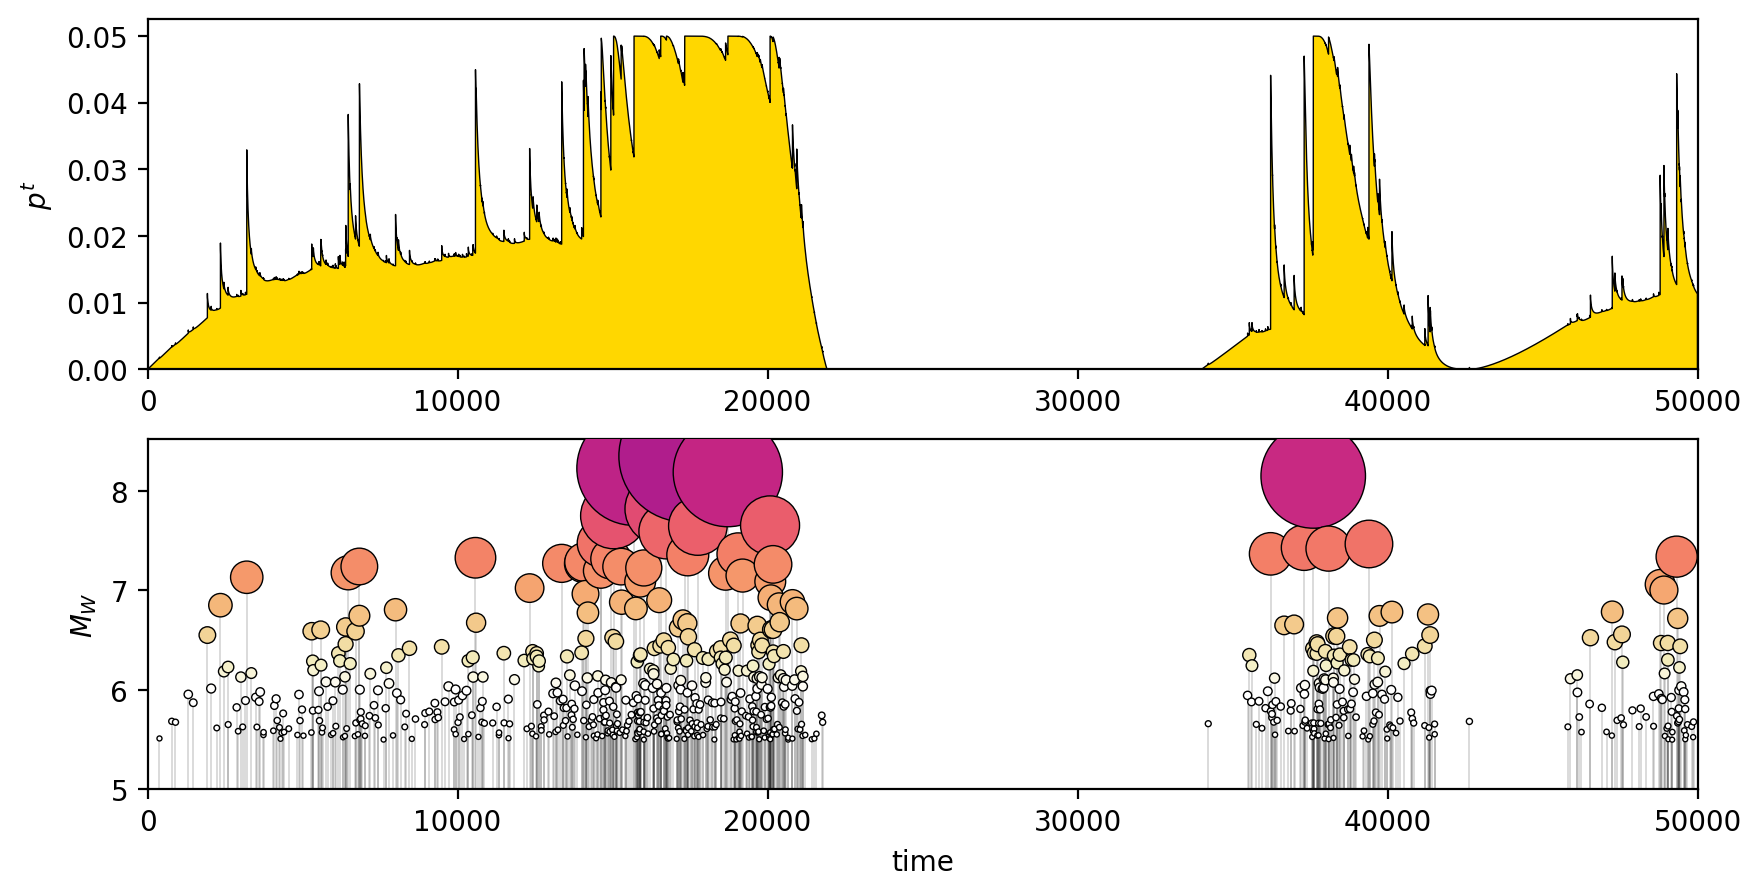

In [10]:
time_series
start_idx = 0
end_idx = len(time_series.time)
minimum_event_moment_magnitude = 5.0

event_idx = np.where(time_series.event_trigger_flag == 1)[0]
figsize = (10, 5)
plt.figure(figsize=figsize)

# Plot probability time series
plt.subplot(2, 1, 1)
plt.plot(
    time_series.time[start_idx:end_idx],
    time_series.probability_weight[start_idx:end_idx],
    "-k",
    linewidth=0.5,
)
plt.plot(
    [time_series.time[start_idx], time_series.time[end_idx - 1]],
    [0, 0],
    "-k",
    linewidth=0.5,
)
plt.fill_between(
    time_series.time[start_idx:end_idx],
    time_series.probability_weight[start_idx:end_idx],
    np.zeros_like(time_series.time[start_idx:end_idx]),
    time_series.probability_weight[start_idx:end_idx] > 0,
    color="gold",
    alpha=1.0,
    edgecolor=None,
)

plt.fill_between(
    time_series.time[start_idx:end_idx],
    time_series.probability_weight[start_idx:end_idx],
    np.zeros_like(time_series.time[start_idx:end_idx]),
    time_series.probability_weight[start_idx:end_idx] < 0,
    color="dodgerblue",
    alpha=1.0,
    edgecolor=None,
)
plt.xlim([start_idx, end_idx])
plt.gca().set_ylim(bottom=0.0)
plt.ylabel("$p^t$")

# Plot earthquake magnitude stem plot
plt.subplot(2, 1, 2)
for i in range(event_idx.size):
    plt.plot(
        [
            time_series.time[event_idx[i]],
            time_series.time[event_idx[i]],
        ],
        [
            minimum_event_moment_magnitude,
            time_series.event_magnitude[event_idx[i]],
        ],
        "-",
        linewidth=0.1,
        zorder=10,
        color="k",
    )

cmap = cc.cm.CET_L17
magnitude_plot_size = 1e-5 * 10 ** time_series.event_magnitude[event_idx]
plt.scatter(
    time_series.time[event_idx],
    time_series.event_magnitude[event_idx],
    s=magnitude_plot_size,
    c=time_series.event_magnitude[event_idx],
    zorder=20,
    alpha=1.0,
    edgecolors="k",
    linewidths=0.5,
    cmap=cmap,
    vmin=6.0,
    vmax=9.0,
)

plt.xlabel("time")
plt.ylabel("$M_W$")
plt.xlim([start_idx, end_idx])
plt.gca().set_ylim(bottom=minimum_event_moment_magnitude)

# Banded contour for a single time

In [ ]:
pl = pv.Plotter()
pl.add_mesh(boundary, color=CONTOUR_LINE_COLOR, line_width=CONTOUR_LINE_WIDTH)
box = pv.Box(mesh.bounds)
pl.add_mesh(box, color="lightgrey", culling="front")
pl.camera.zoom(1.2)
pl.image_scale = 2

CONTOUR_LEVELS = np.linspace(-60, 60, 21)
N_COLORS = len(CONTOUR_LEVELS) - 1
CLIM = [np.min(CONTOUR_LEVELS), np.max(CONTOUR_LEVELS)]

contour, edges = contour_banded(
    mesh,
    CONTOUR_LEVELS,
    rng=CLIM,
    scalars="data",
)

pl.add_mesh(
    contour,
    cmap="RdYlBu_r",
    clim=CLIM,
    scalars="data",
    n_colors=N_COLORS,
    scalar_bar_args=dict(title=f"", **SCALAR_BAR_OPTS),
)
pl.add_mesh(
    edges.GetOutputPort(1), color=CONTOUR_LINE_COLOR, line_width=CONTOUR_LINE_WIDTH
)

cpos = [
    (246.72654935831832, 56.640050977986135, 19.47264855846906),
    (235.64372937685064, 45.67443514953468, -0.9481135945038834),
    (-0.6591979033815945, -0.45237409343002455, 0.6006794517633125),
]

pl.show()


In [ ]:
pl = pv.Plotter(shape=(1, 3), border=False, multi_samples=8, line_smoothing=True)
CONTOUR_LEVELS = np.linspace(-10, 10, 21)
N_COLORS = len(CONTOUR_LEVELS) - 1
CLIM = [np.min(CONTOUR_LEVELS), np.max(CONTOUR_LEVELS)]
CAMERA_ZOOM = 1.0
IMAGE_SCALE = 2
TITLE_POSITION = [0.1, 0.62]
CAMERA_POSITION = [
    (132.7456379797715, 53.03872370660612, 35.03423385946435),
    (134.73400115966797, 33.14949893951416, -0.625),
    (-0.2950474880132869, -0.8413651518097409, 0.45282630349530384),
]

# Coseismic geometric moment
# Plotting this first because it seems to enable 
# colorbar in the center
pl.subplot(0, 1)
SCALAR_BAR_OPTS = dict(
    # Position (coordinates are on the viewport)
    vertical=False,
    height=0.03,
    width=0.5,
    position_x=0.25,
    position_y=0.275,
    # Labels
    title_font_size=16,
    label_font_size=16,
    n_labels=3,
    italic=False,
    fmt="%.1f",
    font_family="arial",
    shadow=False,
)
annotations = {
    0.0: "geometric moment / area (m)",
}

pl.add_mesh(boundary, color=CONTOUR_LINE_COLOR, line_width=CONTOUR_LINE_WIDTH)
box = pv.Box(mesh.bounds)
# pl.add_mesh(box, color="lightgrey", culling="front")
pl.camera.zoom(CAMERA_ZOOM)
pl.image_scale = IMAGE_SCALE
contour, edges = contour_banded(
    mesh,
    CONTOUR_LEVELS,
    rng=CLIM,
    scalars="event_slip",
)
pl.add_mesh(
    contour,
    cmap="RdYlBu_r",
    clim=CLIM,
    scalars="event_slip",
    n_colors=N_COLORS,
    scalar_bar_args=dict(title=f" ", **SCALAR_BAR_OPTS), annotations=annotations,
)
pl.add_mesh(
    edges.GetOutputPort(1), color=CONTOUR_LINE_COLOR, line_width=CONTOUR_LINE_WIDTH
)
pl.camera_position = CAMERA_POSITION
pl.add_text(
    "event",
    position=TITLE_POSITION,
    color="k",
    shadow=False,
    font_size=12,
    viewport=True,
)
pl.add_floor("-z", show_edges=True, edge_color="white", color="lightgray")


# Pre-event geometric moment
pl.subplot(0, 0)
pl.add_mesh(boundary, color=CONTOUR_LINE_COLOR, line_width=CONTOUR_LINE_WIDTH)
box = pv.Box(mesh.bounds)
# pl.add_mesh(box, color="lightgrey", culling="front")
pl.camera.zoom(CAMERA_ZOOM)
pl.image_scale = IMAGE_SCALE
contour, edges = contour_banded(
    mesh,
    CONTOUR_LEVELS,
    rng=CLIM,
    scalars="pre_event_slip_deficit",
)
pl.add_mesh(
    contour,
    cmap="RdYlBu_r",
    clim=CLIM,
    scalars="pre_event_slip_deficit",
    n_colors=N_COLORS,
    scalar_bar_args=dict(title=f" ", **SCALAR_BAR_OPTS), annotations=annotations
)
pl.add_mesh(
    edges.GetOutputPort(1), color=CONTOUR_LINE_COLOR, line_width=CONTOUR_LINE_WIDTH
)
pl.camera_position = CAMERA_POSITION
pl.add_text(
    "pre-event",
    position=TITLE_POSITION,
    color="k",
    shadow=False,
    font_size=12,
    viewport=True,
)
pl.add_floor("-z", show_edges=True, edge_color="white", color="lightgray")


# Post-event slip
pl.subplot(0, 2)


SCALAR_BAR_OPTS = dict(
    # Position (coordinates are on the viewport)
    vertical=False,
    height=0.00,
    width=0.0,
    position_x=0.0,
    position_y=0.0,
    # Labels
    title_font_size=0,
    label_font_size=0,
    n_labels=3,
    italic=False,
    fmt="%.1f",
    font_family="arial",
    shadow=False,
)


pl.add_mesh(boundary, color=CONTOUR_LINE_COLOR, line_width=CONTOUR_LINE_WIDTH)
box = pv.Box(mesh.bounds)
# pl.add_mesh(box, color="lightgrey", culling="front")
pl.camera.zoom(CAMERA_ZOOM)
pl.image_scale = IMAGE_SCALE
contour, edges = contour_banded(
    mesh,
    CONTOUR_LEVELS,
    rng=CLIM,
    scalars="post_event_slip_deficit",
)
pl.add_mesh(
    contour,
    cmap="RdYlBu_r",
    clim=CLIM,
    scalars="post_event_slip_deficit",
    n_colors=N_COLORS,
    scalar_bar_args=dict(title=f"", **SCALAR_BAR_OPTS),
)
pl.add_mesh(
    edges.GetOutputPort(1), color=CONTOUR_LINE_COLOR, line_width=CONTOUR_LINE_WIDTH
)
pl.camera_position = CAMERA_POSITION
pl.add_text(
    "post-event",
    position=TITLE_POSITION,
    color="k",
    shadow=False,
    font_size=12,
    viewport=True,
)
pl.add_floor("-z", show_edges=True, edge_color="white", color="lightgray")

# pl.enable_shadows()
pl.link_views()
pl.show()
print(pl.camera_position)
pl.screenshot("kale_single_step_erosion_figures_nankai.png", scale=3, return_img=False)


# Plot a single time step from the experiment
1. Loading rate
2. Moment
3. Cumulative slip
# ['cumulative_slip', 'geometric_moment', 'last_event_slip', 'loading_rate']

In [ ]:
# idx = 45000
# mesh.cell_data["geometric_moment"] = ds["geometric_moment"][idx, :] # / mesh.cell_data["meshes_areas"] 
# mesh.cell_data["last_event_slip"] = ds["last_event_slip"][idx, :]
# mesh.cell_data["cumulative_slip"] = ds["cumulative_slip"][idx, :]


pl = pv.Plotter(shape=(1, 3), border=False, multi_samples=8, line_smoothing=True)
CONTOUR_LEVELS = np.linspace(0, 15, 11)
# CONTOUR_LEVELS = np.logspace(-1, 1, 11, endpoint=True)
# CONTOUR_LEVELS = np.array([0.1, 0.5, 1.0, 3.0, 5.0, 10.0, 15.0])


N_COLORS = len(CONTOUR_LEVELS) - 1
CLIM = [np.min(CONTOUR_LEVELS), np.max(CONTOUR_LEVELS)]
CAMERA_ZOOM = 1.0
IMAGE_SCALE = 2
TITLE_POSITION = [0.1, 0.62]
CAMERA_POSITION = [
    (132.7456379797715, 53.03872370660612, 35.03423385946435),
    (134.73400115966797, 33.14949893951416, -0.625),
    (-0.2950474880132869, -0.8413651518097409, 0.45282630349530384),
]

# Time step 2: Cumulative slip
# Plotting this first because it seems to enable 
# colorbar in the center
idx = 17000
mesh.cell_data["cumulative_slip_2"] = ds["cumulative_slip"][idx, :]

pl.subplot(0, 1)
SCALAR_BAR_OPTS = dict(
    # Position (coordinates are on the viewport)
    vertical=False,
    height=0.03,
    width=0.5,
    position_x=0.25,
    position_y=0.275,
    # Labels
    title_font_size=16,
    label_font_size=16,
    n_labels=3,
    italic=False,
    fmt="%.1f",
    font_family="arial",
    shadow=False,
)
annotations = {
    7.5: "cumulative slip (m)",
}

pl.add_mesh(boundary, color=CONTOUR_LINE_COLOR, line_width=CONTOUR_LINE_WIDTH)
box = pv.Box(mesh.bounds)
# pl.add_mesh(box, color="lightgrey", culling="front")
pl.camera.zoom(CAMERA_ZOOM)
pl.image_scale = IMAGE_SCALE
contour, edges = contour_banded(
    mesh,
    CONTOUR_LEVELS,
    rng=CLIM,
    scalars="cumulative_slip_2",
)
pl.add_mesh(
    contour,
    cmap="CET_L17",
    clim=CLIM,
    scalars="cumulative_slip_2",
    n_colors=N_COLORS,
    scalar_bar_args=dict(title=f" ", **SCALAR_BAR_OPTS), annotations=annotations,
)
pl.add_mesh(
    edges.GetOutputPort(1), color=CONTOUR_LINE_COLOR, line_width=CONTOUR_LINE_WIDTH
)
pl.camera_position = CAMERA_POSITION
pl.add_text(
    f"i={str(idx)}",
    position=TITLE_POSITION,
    color="k",
    shadow=False,
    font_size=12,
    viewport=True,
)
pl.add_floor("-z", show_edges=True, edge_color="white", color="lightgray")


# Time step 1: Cumulative slip
idx = 10000
mesh.cell_data["cumulative_slip_1"] = ds["cumulative_slip"][idx, :]

pl.subplot(0, 0)
pl.add_mesh(boundary, color=CONTOUR_LINE_COLOR, line_width=CONTOUR_LINE_WIDTH)
box = pv.Box(mesh.bounds)
# pl.add_mesh(box, color="lightgrey", culling="front")
pl.camera.zoom(CAMERA_ZOOM)
pl.image_scale = IMAGE_SCALE
contour, edges = contour_banded(
    mesh,
    CONTOUR_LEVELS,
    rng=CLIM,
    scalars="cumulative_slip_1",
)
pl.add_mesh(
    contour,
    cmap="CET_L17",
    clim=CLIM,
    scalars="cumulative_slip_1",
    n_colors=N_COLORS,
    scalar_bar_args=dict(title=f" ", **SCALAR_BAR_OPTS), annotations=annotations
)
pl.add_mesh(
    edges.GetOutputPort(1), color=CONTOUR_LINE_COLOR, line_width=CONTOUR_LINE_WIDTH
)
pl.camera_position = CAMERA_POSITION
pl.add_text(
    f"i={str(idx)}",
    position=TITLE_POSITION,
    color="k",
    shadow=False,
    font_size=12,
    viewport=True,
)
pl.add_floor("-z", show_edges=True, edge_color="white", color="lightgray")


# Time step 3: Cumulative slip
idx = 24000
mesh.cell_data["cumulative_slip_3"] = ds["cumulative_slip"][idx, :]

pl.subplot(0, 2)
SCALAR_BAR_OPTS = dict(
    # Position (coordinates are on the viewport)
    vertical=False,
    height=0.00,
    width=0.0,
    position_x=0.0,
    position_y=0.0,
    # Labels
    title_font_size=0,
    label_font_size=0,
    n_labels=3,
    italic=False,
    fmt="%.1f",
    font_family="arial",
    shadow=False,
)

pl.add_mesh(boundary, color=CONTOUR_LINE_COLOR, line_width=CONTOUR_LINE_WIDTH)
box = pv.Box(mesh.bounds)
# pl.add_mesh(box, color="lightgrey", culling="front")
pl.camera.zoom(CAMERA_ZOOM)
pl.image_scale = IMAGE_SCALE
contour, edges = contour_banded(
    mesh,
    CONTOUR_LEVELS,
    rng=CLIM,
    scalars="cumulative_slip_3",
)
pl.add_mesh(
    contour,
    cmap="CET_L17",
    clim=CLIM,
    scalars="cumulative_slip_3",
    n_colors=N_COLORS,
    scalar_bar_args=dict(title=f"", **SCALAR_BAR_OPTS),
)
pl.add_mesh(
    edges.GetOutputPort(1), color=CONTOUR_LINE_COLOR, line_width=CONTOUR_LINE_WIDTH
)
pl.camera_position = CAMERA_POSITION
pl.add_text(
    f"i={str(idx)}",
    position=TITLE_POSITION,
    color="k",
    shadow=False,
    font_size=12,
    viewport=True,
)
pl.add_floor("-z", show_edges=True, edge_color="white", color="lightgray")

pl.link_views()
pl.show()
pl.screenshot("kale_single_time_step_cumulative_slip_nankai.png", scale=3, return_img=False)
